In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
import creep_event_picker as cep
import obspy
import cmcrameri.cm as cmc
%matplotlib inline


In [2]:
def check_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(path, exist_ok=True)

Import creepmeter database

In [ ]:
Creepmeter_dataframe = pd.read_excel('../../Data/creepmeter_lookup_and_processing_progress.xlsx',index_col=0)
Creepmeter_dataframe.drop(Creepmeter_dataframe[Creepmeter_dataframe['File_code']!='xmr_1'].index,inplace=True)
#Creepmeter_dataframe.drop([1],inplace=True)
Creepmeter_dataframe.reset_index(inplace=True,drop=True)
Creepmeter_dataframe

In [4]:
cutter = 2
n=10
cmap = cmc.roma #select the colormap

slicedCM = cmap(np.linspace(0, 1, cutter+1)) #list of colors that make up the colormap, can be called by using slicedCM[j] where j is the loop number in the fore loop

In [ ]:
df_all = pd.read_csv("../../Data/all_creep_event_picks_new_qc_Oct_02_2024.csv",index_col=0)

columns = df_all.columns.tolist()
columns.append('Quality_check_final')

try:
    df_new_qc = pd.read_csv('../../Data/QCed_creep_event_catalogue_XMR1_08_OCT_2024.csv',index_col=0)
except FileNotFoundError:
    df_new_qc = pd.DataFrame(columns=columns)
df_new_qc

gathering info for xmr_1
../../Data/Central_San_Andreas_Fault/SAC/xmr_1.SAC
reading & processing SAC data
Identifying events
beginning QC for xmr_1


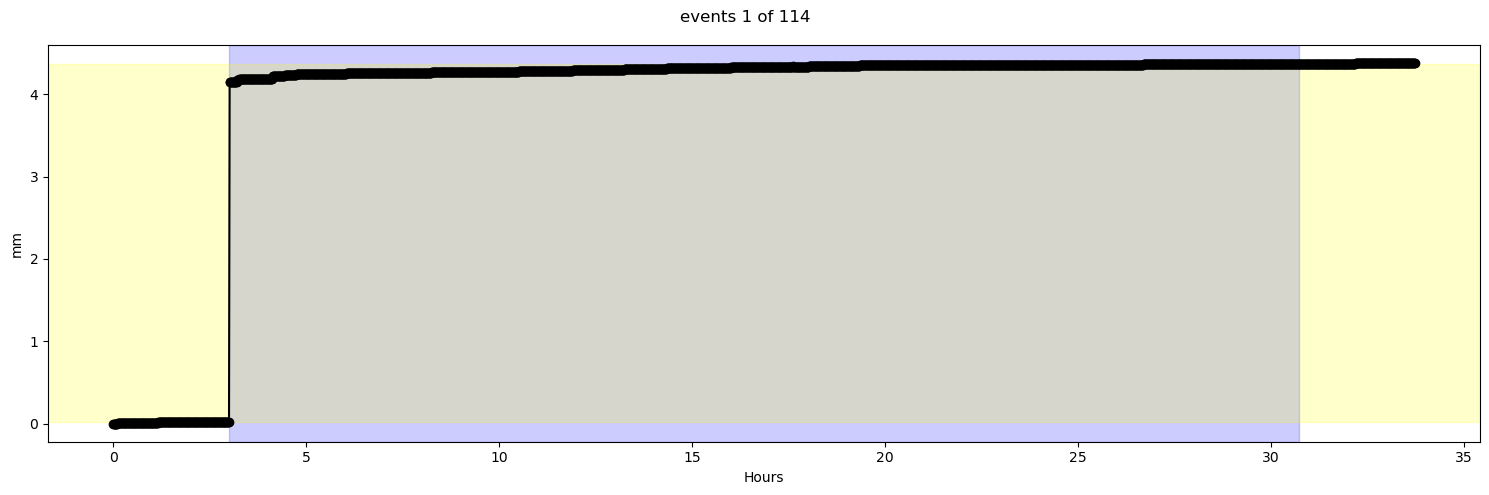

1/114


In [9]:
plt.close('all')
for i in range(len(Creepmeter_dataframe)):
    print('gathering info for {k}'.format(k=Creepmeter_dataframe.File_code.iloc[i]))
    network = Creepmeter_dataframe.Network.iloc[i]
    file_code = Creepmeter_dataframe.File_code.iloc[i]
    if file_code in list(df_new_qc['File_code']):
        print("Alread Qc'ed")
    else:
        path = "../../Data/{p}/SAC/{q}.SAC".format(p=network,q =file_code)
        path_save = "../../Data/{p}/Picks/".format(p=network)
        check_dir(path_save)
        print(path)

        print('reading & processing SAC data')

        st = obspy.read(path)
        tr = st[0]
        tr.interpolate(sampling_rate=tr.stats.sampling_rate)
        tm = tr.times("utcdatetime")
        creep = tr.data
        sample_rate =  round(tr.stats.delta)/60
        tm_dt = []
        for w in range(len(tm)):
            tm_new = tm[w].datetime
            tm_dt.append(tm_new)
        tm_int, creep_int, upsampled = cep.interpolate(tm_dt,creep,sample_rate)
        
        print('Identifying events')
        #df_picks = pd.read_csv("../../Data/{p}/Picks/{q}_picks.csv".format(p=network,q =file_code),index_col=0)
        df_picks = df_all[df_all['File_code']==file_code]
        df_picks.reset_index(inplace=True,drop=True)      
        df_end=df_picks['ET']
        df_start=df_picks['ST']

        print('beginning QC for {k}'.format(k=file_code))
        QC = []
        for p in range(len(df_picks)):
            start = df_start.iloc[p]
            end = df_end.iloc[p]
            fig = plt.figure(figsize=(15,5))
            ax = plt.subplot(1,1,1)

            fig.suptitle('events {a} of {c}'.format(a = p+1,c =len(df_picks) ))
            boolarr_selecta = np.logical_and(np.array(tm_int)>=pd.to_datetime(start).replace(tzinfo=None)
                                            -dt.timedelta(hours=3),np.array(tm_int)<=pd.to_datetime(end).replace(tzinfo=None)
                                            +dt.timedelta(hours = 3))
            tm_selecta = tm_int[boolarr_selecta]
            tm_selecta = (tm_selecta - tm_selecta[0])/np.timedelta64(1, 'h')
            boolarr_event = np.logical_and(np.array(tm_selecta)>=3,np.array(tm_selecta)<=tm_selecta[-1]-3)

            creep_selecta = creep_int[boolarr_selecta]
            creep_selecta = creep_selecta - creep_selecta[0]
            creep_event = creep_selecta[boolarr_event]
            plt.plot(tm_selecta,creep_selecta,color='black',marker='o')
            
            ax.axvspan(tm_selecta[0]+3, tm_selecta[-1]-3, color='blue', alpha=0.2)
            ax.axhspan(creep_event[0],creep_event[-1], color='yellow', alpha=0.2)
            plt.xlabel('Hours')
            plt.ylabel('mm')
        
            fig.tight_layout()
            plt.show()
            ##### QC ####
            print('{m}/{n}'.format(m=p+1,n=len(df_picks)))         
                
            while True:
                user_input = input("Is this event a creep event? (y/n): ").strip().lower()

                if user_input == 'y':
                    QC.append('CE')
                    print("Creep event identified")
                    # Do something for "yes"
                    break
                elif user_input == 'n':
                    QC.append('NCE')
                    print("This event is not a creep event")
                    # Do something for "esc" or just exit
                    break
                else:
                    print("Invalid input! Please enter 'y' to proceed or 'n' to exit.")
            
        

            plt.close() 

        
        df_picks['Quality_check_final'] = QC
        print(df_picks)
        print('QC completed')
        df_new_qc = pd.concat([df_new_qc,df_picks],ignore_index=True)

In [8]:
df_picks

,ST,ET,Quality_check,ET_new,ST_new,Quality_check_new
0,2018-09-14 03:55:00,2018-09-14 06:21:00,NCE,2018-09-14 06:21:00,2018-09-14 03:55:00,NCE
1,2018-09-14 07:30:00,2018-09-14 15:00:00,CE,2018-09-15 11:14:00,2018-09-14 07:30:00,CE
2,2018-10-08 08:57:00,2018-10-08 09:51:00,NCE,2018-10-09 17:28:00,2018-10-08 08:57:00,CE
3,2018-10-08 10:19:00,2018-10-08 11:19:00,NCE,2018-10-08 11:19:00,2018-10-08 10:19:00,NCE
4,2018-10-08 13:39:00,2018-10-08 14:22:00,NCE,2018-10-08 14:22:00,2018-10-08 13:39:00,NCE
...,...,...,...,...,...,...
179,2022-12-02 14:18:00,2022-12-03 04:29:00,CE,2022-12-04 15:03:00,2022-12-02 14:18:00,CE
180,2022-12-22 03:29:00,2022-12-22 14:33:00,CE,2022-12-27 02:49:00,2022-12-22 03:29:00,CE
181,2023-02-08 23:58:00,2023-02-09 06:41:00,NCE,2023-02-14 15:44:00,2023-02-08 23:58:00,CE
182,2023-02-24 08:01:00,2023-02-24 10:45:00,NCE,2023-02-24 10:45:00,2023-02-24 08:01:00,CE


In [ ]:
df_new_qc

In [104]:
df_new_qc.drop(df_new_qc[df_new_qc['Quality_check_final']!='CE'].index,inplace=True)

In [106]:
df_new_qc.to_csv('../../Data/QCed_creep_event_catalogue_XMR1.csv')